In [1]:
from birdset.datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule import LoadersConfig, LoaderConfig

dm = BirdSetDataModule(
    dataset=DatasetConfig(
        data_dir="./datasets",
        hf_path="DBD-research-group/BirdSet",
        hf_name="POW",
        n_workers=21,
        val_split=0.2,
        task="multiclass",
        classlimit=500,
        eventlimit=5,
        sample_rate=32000,
    ),
    loaders=LoadersConfig(
        train=LoaderConfig(batch_size=8, shuffle=True),
        valid=LoaderConfig(batch_size=8, shuffle=False),
        test=LoaderConfig(batch_size=8, shuffle=True),
    ),
)

dm.prepare_data()
dm.setup(stage="fit")

train_loader = dm.train_dataset
validation_loader = dm.val_dataset


c:\Users\johnd\anaconda3\envs\birdset\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\johnd\anaconda3\envs\birdset\lib\site-packages\torch_audiomentations\utils\io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
sampling: 100%|██████████| 48/48 [00:04<00:00, 10.29it/s]


Saving the dataset (0/1 shards):   0%|          | 0/41115 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10279 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16052 [00:00<?, ? examples/s]

In [2]:
import tensorflow as tf
import numpy as np

num_classes = dm.num_classes

def data_generator(dataset, augment=False):
    for sample in dataset:
        # Get audio and label
        audio = sample['input_values']
        label = sample['labels']
        
        # Handle the shape - BirdSet returns shape (1, 32000) or (batch, 32000)
        if isinstance(audio, np.ndarray):
            audio = audio.flatten()  # Force to 1D
        else:
            audio = audio.numpy().flatten()  # Force to 1D
        
        # Ensure audio is exactly 1D with 32000 samples
        if audio.shape[0] != 32000:
            # Pad or trim to 32000
            if audio.shape[0] < 32000:
                audio = np.pad(audio, (0, 32000 - audio.shape[0]), mode='constant')
            else:
                audio = audio[:32000]
        
        # Extract label and convert to int
        if isinstance(label, np.ndarray):
            label = int(label.item() if label.size == 1 else label.flat[0])
        else:
            label = int(label.numpy().item() if label.numpy().size == 1 else label.numpy().flat[0])
        
        audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
        audio_tensor = tf.reshape(audio_tensor, [-1])
        
        # Compute STFT
        stft = tf.signal.stft(audio_tensor, frame_length=2048, frame_step=512, fft_length=2048)
        spectrogram = tf.abs(stft)
        
        # Convert to mel scale (80 mel bins is standard)
        num_spectrogram_bins = spectrogram.shape[-1]
        lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
        num_mel_bins = 128
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins, num_spectrogram_bins, 32000, lower_edge_hertz, upper_edge_hertz
        )
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
        
        # Convert to log scale (dB)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
        
        # Convert to numpy
        spectrogram = log_mel_spectrogram.numpy()
        
        # Transpose to (time, mel_bins)
        spectrogram = spectrogram.T
        
        # Add channel dimension
        spectrogram = spectrogram[..., np.newaxis]
        
        # Resize to 224x224x1
        spectrogram_resized = tf.image.resize(spectrogram, [224, 224], method='bilinear').numpy()
        
        # Repeat to 3 channels
        spectrogram_3ch = np.repeat(spectrogram_resized, 3, axis=-1)

        # Normalize to [0, 1]
        spec_min = spectrogram_3ch.min()
        spec_max = spectrogram_3ch.max()
        spectrogram_3ch = (spectrogram_3ch - spec_min) / (spec_max - spec_min + 1e-8)

        # One-hot encode labels
        label_onehot = tf.one_hot(label, num_classes).numpy()

        if augment:
            # Random time/frequency masking (SpecAugment)
            spectrogram_3ch = tf.image.random_brightness(spectrogram_3ch, 0.2).numpy()
            
            # Random horizontal flip (time reversal)
            if np.random.random() > 0.5:
                spectrogram_3ch = np.flip(spectrogram_3ch, axis=1)
        
        yield spectrogram_3ch.astype(np.float32), label_onehot.astype(np.float32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(dm.train_dataset, augment=False),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    )
).batch(8).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(dm.val_dataset),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    )
).batch(8).prefetch(tf.data.AUTOTUNE)

In [3]:
# We want to use Tensorflow Keras for the model
import keras as ks
from keras.layers import Dense, Dropout

num_classes = dm.num_classes

# Copy efficientnetb0 architecture
model = ks.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

x = model.output
x = Dropout(0.3)(x)
x = Dense(num_classes, activation='softmax')(x)
model = ks.models.Model(inputs=model.input, outputs=x)


In [4]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
                metrics=['accuracy'])

In [10]:
model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=callbacks)

Epoch 1/5
5140/5140 [==============================] - 3304s 643ms/step - loss: 2.3108 - accuracy: 0.3762 - val_loss: 3.1457 - val_accuracy: 0.2417 - lr: 2.5000e-04
Epoch 2/5
5140/5140 [==============================] - 3206s 624ms/step - loss: 2.2465 - accuracy: 0.3936 - val_loss: 3.0768 - val_accuracy: 0.2516 - lr: 2.5000e-04
Epoch 3/5
5140/5140 [==============================] - 3056s 595ms/step - loss: 2.1867 - accuracy: 0.4100 - val_loss: 3.1157 - val_accuracy: 0.2537 - lr: 2.5000e-04
Epoch 4/5
5140/5140 [==============================] - 3361s 654ms/step - loss: 2.1252 - accuracy: 0.4249 - val_loss: 3.1082 - val_accuracy: 0.2596 - lr: 2.5000e-04
Epoch 5/5
5140/5140 [==============================] - 3167s 616ms/step - loss: 2.0542 - accuracy: 0.4435 - val_loss: 3.1549 - val_accuracy: 0.2527 - lr: 2.5000e-04


In [ ]:
model.save("birdset_model.h5")

In [ ]:
import librosa

def preprocess_audio(audio_path):
        sample_rate = 32000
        audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
        
        if len(audio) > 32000:
            start = (len(audio) - 32000) // 2
            audio = audio[start:start + 32000]
        elif len(audio) < 32000:
            audio = np.pad(audio, (0, 32000 - len(audio)), mode='constant')
        
        audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
        
        stft = tf.signal.stft(audio_tensor, frame_length=2048, frame_step=512, fft_length=2048)
        spectrogram = tf.abs(stft)
        
        num_spectrogram_bins = spectrogram.shape[-1]
        lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
        num_mel_bins = 128
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins, num_spectrogram_bins, sample_rate, 
            lower_edge_hertz, upper_edge_hertz
        )
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
            linear_to_mel_weight_matrix.shape[-1:]))
        
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
        
        spectrogram = log_mel_spectrogram.numpy().T
        
        spectrogram = spectrogram[..., np.newaxis]
        
        spectrogram_resized = tf.image.resize(spectrogram, [224, 224], method='bilinear').numpy()
        
        spectrogram_3ch = np.repeat(spectrogram_resized, 3, axis=-1)
        
        spec_min = spectrogram_3ch.min()
        spec_max = spectrogram_3ch.max()
        spectrogram_3ch = (spectrogram_3ch - spec_min) / (spec_max - spec_min + 1e-8)
        
        return spectrogram_3ch.astype(np.float32)

In [28]:
def predict(audio_path, top_k=5):
    spectrogram = preprocess_audio(audio_path)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # Add batch dimension
    predictions = model.predict(spectrogram)
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_probs = predictions[0][top_indices]
    int2str = dm.train_dataset.features['labels'].int2str
    
    results = [(int2str(int(idx)), float(prob)) for idx, prob in zip(top_indices, top_probs)]
    return results 

In [59]:
predictions = predict("./XC180282 - Northern Cardinal - Cardinalis cardinalis.mp3")

print(predictions)

1/1 [==============================] - 0s 26ms/step
[('norcar', 0.8728644847869873), ('amerob', 0.11017926037311554), ('comrav', 0.015788285061717033), ('bnhcow', 0.0007227985770441592), ('swathr', 0.00043203760287724435)]


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_raw_spectrogram(audio_path):
    sample_rate = 32000
    audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
        
    if len(audio) > 32000:
        start = (len(audio) - 32000) // 2
        audio = audio[start:start + 32000]
    elif len(audio) < 32000:
        audio = np.pad(audio, (0, 32000 - len(audio)), mode='constant')
        
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sample_rate, 
        n_fft=2048, hop_length=512, n_mels=128,
        fmin=80, fmax=7600
    )
        
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
    img1 = axes[0].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_xlabel('Time Frame')
    axes[0].set_ylabel('Mel Frequency Bins')
    axes[0].set_title(f'Raw Mel Spectrogram (128 mel bins): {Path(audio_path).name}')
    plt.colorbar(img1, ax=axes[0], label='dB')
        
    preprocessed = preprocess_audio(audio_path)
    img2 = axes[1].imshow(preprocessed[:, :, 0], aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_xlabel('Time (resized to 224)')
    axes[1].set_ylabel('Frequency (resized to 224)')
    axes[1].set_title('Preprocessed Spectrogram (224x224, normalized)')
    plt.colorbar(img2, ax=axes[1], label='Normalized Value')
        
    plt.tight_layout()
    plt.show()

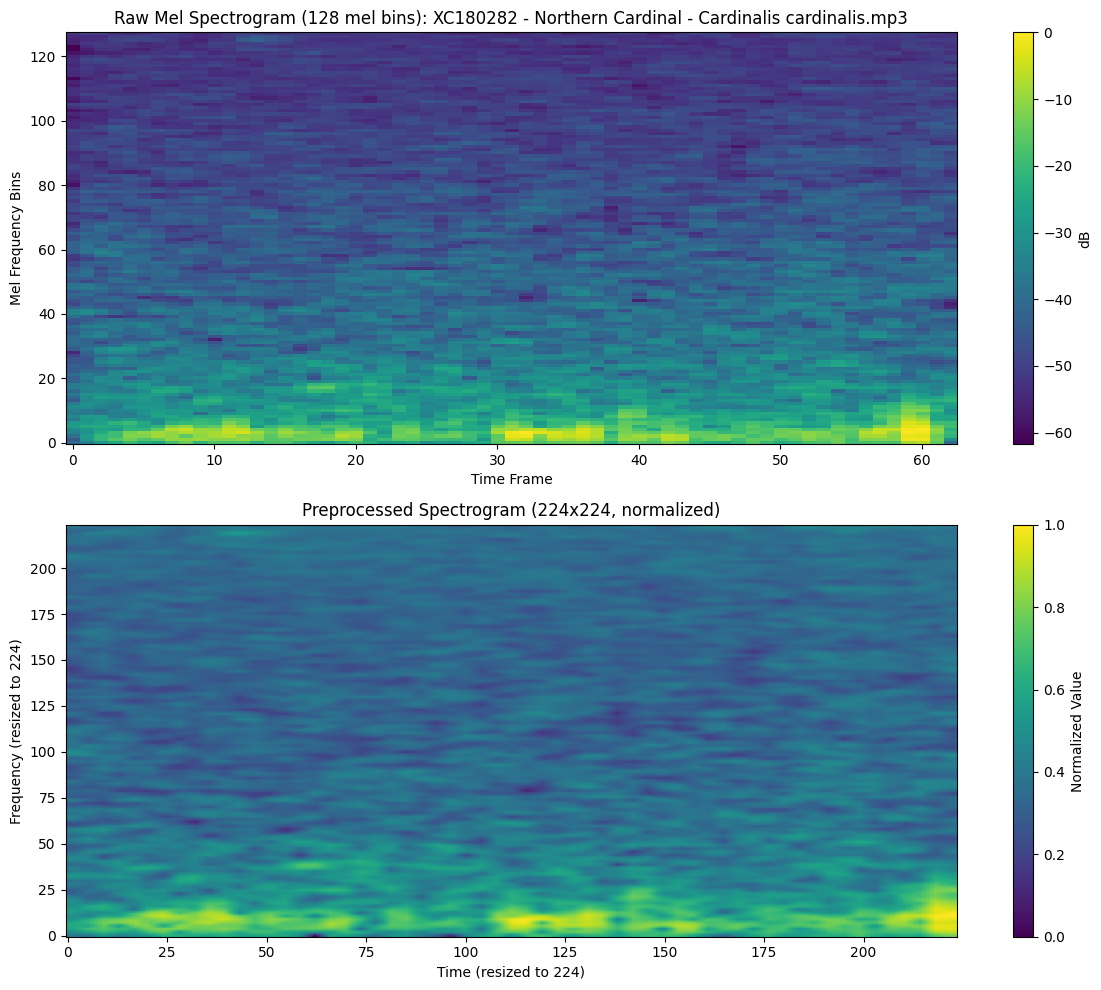

In [60]:
plot_raw_spectrogram("./XC180282 - Northern Cardinal - Cardinalis cardinalis.mp3")